In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import  train_test_split
 
import tensorflow as tf
from tensorflow.keras import regularizers
import pandas as pd
from random import seed
from random import random
# seed the generator
#np.random.seed(123)
#tf.random.set_seed(1234)

In [2]:
import pandas as pd
data = pd.read_excel('crude oil dataset/Brent 6monthly2020 - Copy.xlsx')
data = data.set_index('Month')

In [3]:
data.tail()

,real,t
Month,,
Oct 2021,89.941667,74.49
Nov 2021,93.448333,83.54
Dec 2021,98.830000,81.05
Jan 2022,106.920000,74.17
Feb 2022,111.156667,86.51


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
values = data.values
values = values.astype('float32')

In [6]:
ab= series_to_supervised(values,2,1)
ab.columns

Index(['var1(t-2)', 'var2(t-2)', 'var1(t-1)', 'var2(t-1)', 'var1(t)',
       'var2(t)'],
      dtype='object')

In [7]:
reframed = series_to_supervised(values,2,1)
# drop columns we don't want to predict. var1(t) should NOT be dropped. all the var1(t+j) columns MUST be dropped.
#sometimes, vari(t+j) columns need to be dropped as well, depending on the question
reframed.drop(reframed.columns[[5]], axis=1, inplace=True)

reframed.tail()

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
17,78.418335,75.169998,82.815002,70.750000,89.941666
18,82.815002,70.750000,89.941666,74.489998,93.448334
19,89.941666,74.489998,93.448334,83.540001,98.830002
20,93.448334,83.540001,98.830002,81.050003,106.919998
21,98.830002,81.050003,106.919998,74.169998,111.156670


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,2,1)
# drop columns we don't want to predict. var1(t) should NOT be dropped. all the var1(t+j) columns MUST be dropped.
#sometimes, vari(t+j) columns need to be dropped as well, depending on the question
reframed.drop(reframed.columns[[5]], axis=1, inplace=True)
reframed.tail()


,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
17,0.541277,0.833553,0.602882,0.768677,0.702739
18,0.602882,0.768677,0.702739,0.823573,0.751874
19,0.702739,0.823573,0.751874,0.956407,0.827281
20,0.751874,0.956407,0.827281,0.919859,0.940637
21,0.827281,0.919859,0.940637,0.818876,1.000000


In [9]:
values = reframed.values

#pay attention here, for predicting the next 6 month in one go, the testing set need to be at least
# 5 points after the training set
n_train = 12
train = values[:n_train]
#val = values[n_train:n_train+10]
test = values[n_train+5:]
trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

#valX,valY=val[:,:-1],val[:,-1]


In [10]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(12, 4) (12,) (3, 4) (3,)


In [11]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])
#valX = valX.reshape(valX.shape[0],1,valX.shape[1])

In [12]:
print(trainX.shape)
print(testX.shape)

(12, 1, 4)
(3, 1, 4)


In [13]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(5, activation='relu',input_shape=(trainX.shape[1],trainX.shape[2])),
#tf.keras.layers.Dense(3, activation='relu'),
#tf.keras.layers.Dense(2, activation='relu'),
tf.keras.layers.Dense(1)
])
model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
model.summary()

#save the model by decommenting the next line
#tf.keras.models.save_model(model=model, filepath='tmp/modelrmse14mae11')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 5)              25        
                                                                 
 dense_1 (Dense)             (None, 1, 1)              6         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

history = model.fit(trainX,trainY, validation_data=(testX,testY), epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 0.4738 - val_loss: 1.2137 - 713ms/epoch - 713ms/step
Epoch 2/200
1/1 - 0s - loss: 0.4695 - val_loss: 1.2053 - 20ms/epoch - 20ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4651 - val_loss: 1.1969 - 21ms/epoch - 21ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4608 - val_loss: 1.1886 - 19ms/epoch - 19ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4564 - val_loss: 1.1802 - 22ms/epoch - 22ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4521 - val_loss: 1.1718 - 21ms/epoch - 21ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4477 - val_loss: 1.1635 - 20ms/epoch - 20ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4434 - val_loss: 1.1551 - 20ms/epoch - 20ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4390 - val_loss: 1.1468 - 20ms/epoch - 20ms/step
Epoch 10/200
1/1 - 0s - loss: 0.4347 - val_loss: 1.1384 - 21ms/epoch - 21ms/step
Epoch 11/200
1/1 - 0s - loss: 0.4304 - val_loss: 1.1301 - 19ms/epoch - 19ms/step
Epoch 12/200
1/1 - 0s - loss: 0.4260 - val_loss: 1.1217 - 21ms/epoch - 21ms/step
Epoch 13/200
1/1 - 0s - loss: 0.421

Epoch 103/200
1/1 - 0s - loss: 0.1650 - val_loss: 0.5039 - 18ms/epoch - 18ms/step
Epoch 104/200
1/1 - 0s - loss: 0.1644 - val_loss: 0.5003 - 19ms/epoch - 19ms/step
Epoch 105/200
1/1 - 0s - loss: 0.1638 - val_loss: 0.4969 - 19ms/epoch - 19ms/step
Epoch 106/200
1/1 - 0s - loss: 0.1633 - val_loss: 0.4935 - 18ms/epoch - 18ms/step
Epoch 107/200
1/1 - 0s - loss: 0.1628 - val_loss: 0.4902 - 19ms/epoch - 19ms/step
Epoch 108/200
1/1 - 0s - loss: 0.1623 - val_loss: 0.4869 - 18ms/epoch - 18ms/step
Epoch 109/200
1/1 - 0s - loss: 0.1618 - val_loss: 0.4837 - 20ms/epoch - 20ms/step
Epoch 110/200
1/1 - 0s - loss: 0.1613 - val_loss: 0.4806 - 20ms/epoch - 20ms/step
Epoch 111/200
1/1 - 0s - loss: 0.1608 - val_loss: 0.4775 - 18ms/epoch - 18ms/step
Epoch 112/200
1/1 - 0s - loss: 0.1603 - val_loss: 0.4744 - 18ms/epoch - 18ms/step
Epoch 113/200
1/1 - 0s - loss: 0.1599 - val_loss: 0.4714 - 20ms/epoch - 20ms/step
Epoch 114/200
1/1 - 0s - loss: 0.1594 - val_loss: 0.4684 - 19ms/epoch - 19ms/step
Epoch 115/200
1/

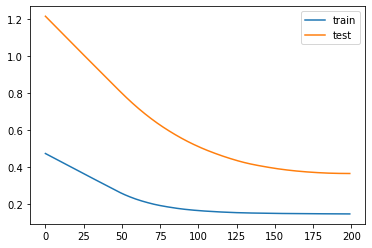

In [15]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [16]:
#load the model by decommenting the next line
#tf.keras.models.save_model(model=model, filepath='tmp/modell')
#del model  # deletes the existing model
#model = tf.keras.models.load_model('tmp/noprodconsumfirstmonth1')
predicted = model.predict(testX)

In [17]:
print(testX.shape)
testXRe = testX.reshape(testX.shape[0],testX.shape[2])
predicted = predicted.reshape(-1,1)

(3, 1, 4)


In [18]:
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

In [19]:
predicted1 = predicted

In [20]:
#some arrangments might need to be made here.
#sometimes more columns need to be deleted, or less. point is, shapes need to be matched.
#make sure to NEVER delete the first column. this is the one containing the actual predictions.
for i in range(0,predicted.shape[1]-2):
    predicted = np.delete(predicted,1,1)
print(predicted)

[[0.5072113  0.95640683]
 [0.56380904 0.91985905]
 [0.59846836 0.81887555]]


In [21]:
predicted = scaler.inverse_transform(predicted)

In [22]:
testY = testY.reshape(len(testY),1)

In [23]:
testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

In [24]:
#some arrangments might need to be made here.
#sometimes more columns need to be deleted, or less. point is, shapes need to be matched.
#make sure to NEVER delete the first column. this is the one containing the actual values.
for i in range(0,testY.shape[1]-2):
    testY = np.delete(testY,1,1)
testY = scaler.inverse_transform(testY)

In [25]:
print(testY)

[[ 98.83     83.54   ]
 [106.92     81.05   ]
 [111.15666  74.17   ]]


In [26]:
mean_predicted = np.mean(predicted[:,0])
mean_test = np.mean(testY[:,0])
print("MAE is: ",mean_absolute_error(testY[:,0],predicted[:,0]))
print("RMSE is: ",np.sqrt(mean_squared_error(testY[:,0],predicted[:,0])))
print(mean_test,mean_predicted)

MAE is:  26.131006
RMSE is:  26.244116
105.63556 79.50455


In [27]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(testY[:,0])],axis=1)
result.columns = ['thetahat','theta']
result['diff'] = result['thetahat'] - result['theta']

In [28]:
result

,thetahat,theta,diff
0,75.987167,98.830002,-22.842834
1,80.026451,106.919998,-26.893547
2,82.500023,111.156662,-28.656639


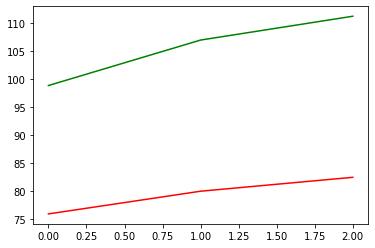

In [29]:
plt.plot(testY[:,0],'g', predicted[:,0], 'r')